# Simple Portfolio Optimization

We consider a classical portfolio problem with $n$ assets held over a period of time. We let $x_i$ denote the amount of asset $i$ held throughout the period. We let $p_i$ denote the relative price change of asset $i$ over the period, i.e., its change in price over the period divided by its price at the beginning of the period. The overall return on the portfolio is,

\begin{equation}
r = \sum_i^n p_i x_i
\end{equation}

**The problem consists how to buy and sell assets $x \in R^n$ in order to have the highest return and/or lowest risk, subject to a budget and other constraints.** This problem is well discussed on page 150 of [cvx-book](https://web.stanford.edu/~boyd/cvxbook/).

In [160]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from cvxpy import *
import scipy.stats as stats

## Problem data

We consider a stochastic model for prices change by assuming $p \in \mathbb{R}^n$ is a random variable with mean $\bar{p}$ and covariance $\Sigma$. Consequently, the return r is also a random variable with mean $\bar{p}^T x$ and variance $x^T \Sigma x$. Then, the choice of portfolio involves a trade-off between the expected return (mean) and its risk (variance). 

* $n$ assests
* $x \in \mathbb{R}^n$ portfolio
* $\bar{p} \in \mathbb{R}^n$ prices mean
* $\Sigma \in \mathbb{R}^{n \times n}$ prices variance

In [161]:
n = 20
pbar = np.ones((n,1))*.03 + np.r_[np.random.rand(n-1,1), np.zeros((1,1))]*.12;
S = np.random.randn(n, n); S = np.asmatrix(S)
S = S.T*S
S = S/max(np.abs(np.diag(S)))*.2
S[:, -1] = np.zeros((n, 1))
S[-1, :] = np.zeros((n, 1)).T

## Minimum-risk portfolio

The classical portfolio problem cosists of minimizing the risk of achiving a minimum acceptable return satisfying the portfolio budget and other constraints. Here, we will use the return achieved by an uniform portfolio as the minimum acceptable return and evaluate the portfolio risk under different constraints.

* Uniform portfolio:
\begin{equation}
x_i = \frac{1}{n},~for~i=0, \ldots, n\\
r_{min} = \bar{p}^T x_{uni} = \bar{p}^T \frac{1}{n}\mathbf{1}  
\end{equation}


In [61]:
# Uniform portfolio
x_unif = np.ones((n, 1))/n;
r_unif = np.ravel(np.dot(pbar.T, x_unif))[0]
std_unif = np.ravel(np.sqrt(np.dot(np.dot(x_unif.T, S), x_unif)))[0]
print("> Uniform portfolio: {}".format(np.ravel(x_unif)))
print(" return: {:.2f}%".format(r_unif * 100))
print(" risk: {:.2f}%".format(std_unif * 100))

> Uniform portfolio: [ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
 return: 9.09%
 risk: 6.89%


* Minimum-risk portfolio:
\begin{equation}
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{minimize}}
& & x^T \Sigma x \\
& \text{subject to}
& &   \bar{p}^T x \geq r_{min} \\
& & & \mathbf{1}^T x = 1
\end{aligned}
\end{equation}

In [162]:
# Miminum risk
x = Variable(n, 1)
prob = Problem(Minimize(quad_form(x, S)), [pbar.T * x >= r_unif, sum_entries(x) == 1])
prob.solve()
x_mr = np.ravel(x.value)
r_mr = np.ravel(np.dot(pbar.T, x.value))[0]
std_mr = np.sqrt(prob.value)
print("> Minimum-risk portfolio: {}".format(x_mr))
print(" return: {:.2f}%".format(r_mr * 100))
print(" risk: {:.2f}%".format(std_mr * 100))

> Minimum-risk portfolio: [ 0.05566  0.1499   0.10681  0.14011  0.18062  0.20085 -0.16343 -0.10608
 -0.00177  0.25883  0.13695 -0.08317 -0.0344  -0.0354  -0.12065  0.12712
  0.19599  0.18671 -0.15465 -0.04001]
 return: 9.09%
 risk: 2.59%


* Markowitz portifolio: The classical portfolio optimization problem was introduced by Markowitz. In his version, there is a non-short position constraint.

\begin{equation}
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{minimize}}
& & x^T \Sigma x \\
& \text{subject to}
& &   \bar{p}^T x \geq r_{min} \\
& & & \mathbf{1}^T x = 1 \\
& & & x \succeq 0
\end{aligned}
\end{equation}

In [163]:
# Markowitz portfolio
x = Variable(n, 1)
prob = Problem(Minimize(quad_form(x, S)), [pbar.T * x >= r_unif, sum_entries(x) == 1, x >= 0])
prob.solve()
x_mp = np.ravel(x.value)
r_mp = np.ravel(np.dot(pbar.T, x.value))[0]
std_mp = np.sqrt(prob.value)
print("> Markowitz portfolio: {}".format(x_mp))
print(" return: {:.2f}%".format(r_mp * 100))
print(" risk: {:.2f}%".format(std_mp * 100))

> Markowitz portfolio: [ 0.03879  0.07239  0.       0.06317  0.13731  0.09242  0.       0.00867
  0.       0.13492  0.00871  0.0198   0.       0.       0.       0.04717
  0.11426  0.15636  0.       0.10604]
 return: 9.09%
 risk: 4.72%


* Limited short positions: Another extension is to allow short positions until a limited percentage of the portfolio.

\begin{equation}
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{minimize}}
& & x^T \Sigma x \\
& \text{subject to}
& &   \bar{p}^T x \geq r_{min} \\
& & & \mathbf{1}^T x = 1 \\
& & & \mathbf{1}^T max(-x, 0) \leq 0.5
\end{aligned}
\end{equation}


In [164]:
# Limited short positions
x = Variable(n, 1)
prob = Problem(Minimize(quad_form(x, S)), [pbar.T * x >= r_unif, sum_entries(x) == 1, sum_entries(pos(-x)) <= 0.5])
prob.solve()
x_ls = np.ravel(x.value)
r_ls = np.ravel(np.dot(pbar.T, x.value))[0]
std_ls = np.sqrt(prob.value)
print("> Limited short positions portfolio: {}".format(x_ls))
print(" return: {:.2f}%".format(r_ls * 100))
print(" risk: {:.2f}%".format(std_ls * 100))

> Limited short positions portfolio: [ 0.06552  0.13444  0.05422  0.11522  0.16497  0.16347 -0.11678 -0.04911
 -0.       0.23711  0.10706 -0.05282 -0.01156 -0.03289 -0.09053  0.09807
  0.17273  0.18719 -0.13042 -0.01589]
 return: 9.09%
 risk: 2.73%


### Results

The portfolios have the same expected return as required, but their risk profiles differ drastically which means we can achieve the desired return with less risk. In addition, note that all of these problems are **quadratic programs (QP)** since the objective is convex quadratic with $\Sigma \in S^n_+$ and the constraints are linear.

([<matplotlib.axis.XTick at 0x7ff3f3e202b0>,
 <a list of 4 Text xticklabel objects>)

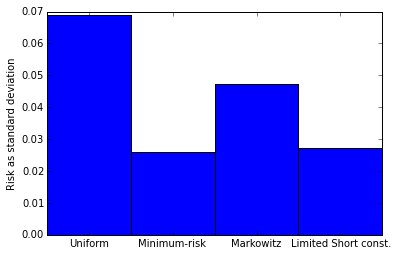

In [165]:
# Plot results
plt.bar(range(4), [std_unif, std_mr, std_mp, std_ls], 1)
plt.ylabel('Risk as standard deviation')
plt.xticks(np.arange(4) + 0.5, ('Uniform', 'Minimum-risk', 'Markowitz', 'Limited Short const.'))

## Optimal risk-return trade-off

The classical portfolio optimization problem can also be expressed as the simultaneous maximization of the return and minimization of the risk associated with a given portfolio. In other words, this is equivalent to minimize the neagative return mean and minimize the return variance in a bi-criterion problem.

\begin{equation}
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{minimize (w.r.t $\mathbb{R}^2_+$)}}
& & (-\bar{p}^T x, x^T \Sigma x) \\
& \text{subject to}
& & \mathbf{1}^T x = 1 \\
& & & x \succeq 0
\end{aligned}
\end{equation}

We can apply the scalarization technique in this problem to find the pareto optimal and minimial elements by solving a series of QPs for different $\lambda$ values.

\begin{equation}
\begin{aligned}
& \underset{x \in \mathbb{R}^n}{\text{minimize}}
& & -\bar{p}^T x + \lambda x^T \Sigma x \\
& \text{subject to}
& & \mathbf{1}^T x = 1 \\
& & & x \succeq 0
\end{aligned}
\end{equation}



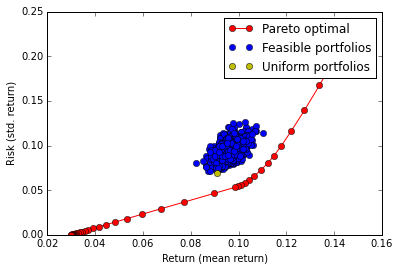

In [166]:
# OPtimal risk-return tradeof
num_vals = 50
lamb_vals = np.logspace(-1, 4, num=num_vals)
port, obj, ret, risk = np.zeros((num_vals, n)), np.zeros(num_vals), np.zeros(num_vals), np.zeros(num_vals) 
x = Variable(n, 1)
lamb = Parameter(sign='Positive')
prob = Problem(Minimize(-pbar.T*x + lamb*quad_form(x, S)), [sum_entries(x) == 1, x >= 0])
for idx, val in enumerate(lamb_vals):
    # Solve a QP
    lamb.value = val
    prob.solve()
    port[idx] = np.ravel(x.value)
    obj[idx] = prob.value
    ret[idx] = np.ravel(np.dot(pbar.T, x.value))[0]
    risk[idx] = np.ravel(np.sqrt(np.dot(np.dot(x.value.T, S), x.value)))[0]


# generating feasible portfolios
rand_points = 1000
rand_ret, rand_risk = np.zeros(rand_points), np.zeros(rand_points) 
for idx in range(rand_points):
    rand_port = np.random.rand(n)
    rand_port = np.reshape(rand_port / rand_port.sum(), (n,1))
    rand_ret[idx] = np.ravel(np.dot(pbar.T, rand_port))[0]
    rand_risk[idx] = np.ravel(np.sqrt(np.dot(np.dot(rand_port.T, S), rand_port)))[0]

    
# Plots
plt.plot(ret, risk, 'o-', c='r', label='Pareto optimal')
plt.plot(rand_ret, rand_risk, 'o', c='b', label='Feasible portfolios')
plt.plot([r_unif], [std_unif], 'o', c='y', label='Uniform portfolios')
plt.xlabel('Return (mean return)')
plt.ylabel('Risk (std. return)')
plt.legend()